In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import ishigami, ishigami_true_indices
from shapley.plots import set_style_paper, violin_plot_indices

import time

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

In [2]:
dim = 3
model = ishigami
margins = [ot.Uniform(-np.pi, np.pi)]*dim
copula = ot.IndependentCopula(dim)
input_distribution = ot.ComposedDistribution(margins, copula)
ot.RandomGenerator.SetSeed(0)

n_sample_gp: 100, max_budget: 50
MC var: [ 0.01308316  0.01201617  0.00869179]
Kriging var: [ 0.02153496  0.0149525   0.01228214]
Sum of vars: [ 0.03461812  0.02696867  0.02097393]
Total var: [ 0.02495732  0.0193645   0.01506945]
Elapsed time: 2.11 s

n_sample_gp: 500, max_budget: 50
MC var: [ 0.0019224   0.00223554  0.00210873]
Kriging var: [ 0.0067326   0.00452423  0.00305827]
Sum of vars: [ 0.008655    0.00675977  0.005167  ]
Total var: [ 0.00723504  0.00520668  0.00382813]
Elapsed time: 19.59 s

n_sample_gp: 1000, max_budget: 50
MC var: [ 0.00099867  0.00114458  0.00132758]
Kriging var: [ 0.00608226  0.00234064  0.00268724]
Sum of vars: [ 0.00708092  0.00348522  0.00401482]
Total var: [ 0.00635252  0.0027338   0.00318833]
Elapsed time: 72.94 s

n_sample_gp: 2000, max_budget: 50
MC var: [ 0.00051432  0.00055262  0.00060988]
Kriging var: [ 0.00602182  0.0020548   0.00152613]
Sum of vars: [ 0.00653614  0.00260742  0.00213601]
Total var: [ 0.00614561  0.00224598  0.00174662]
Elapsed ti

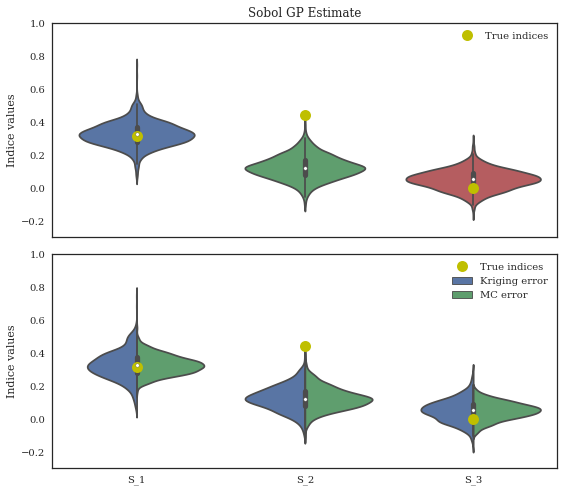

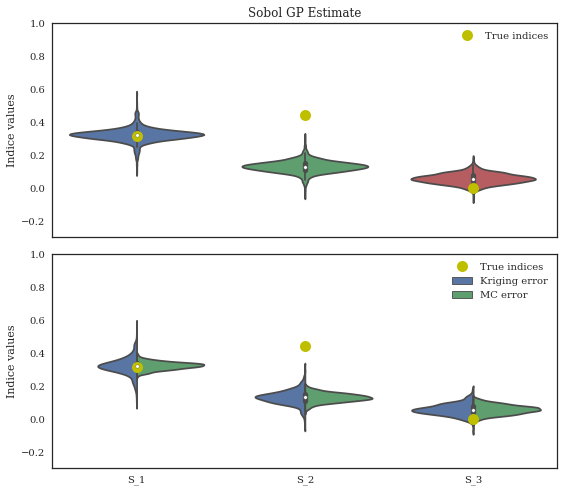

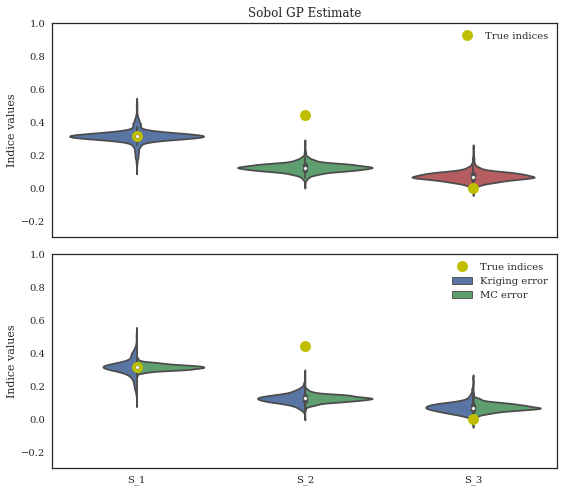

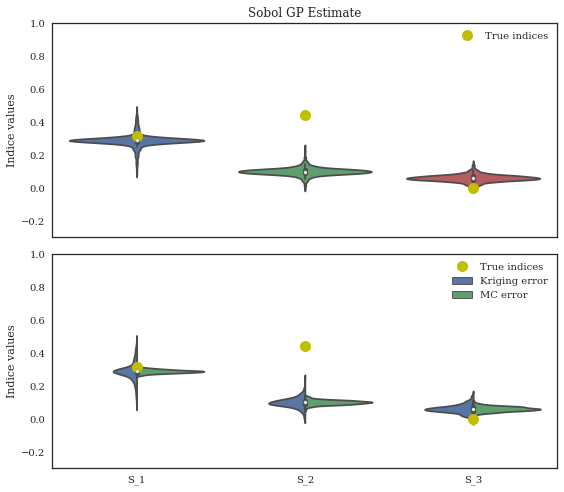

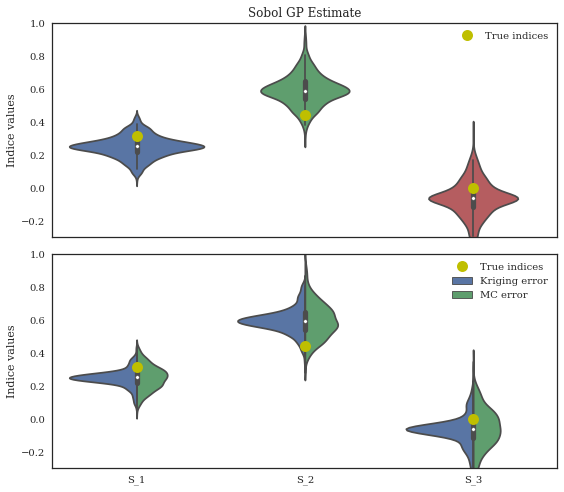

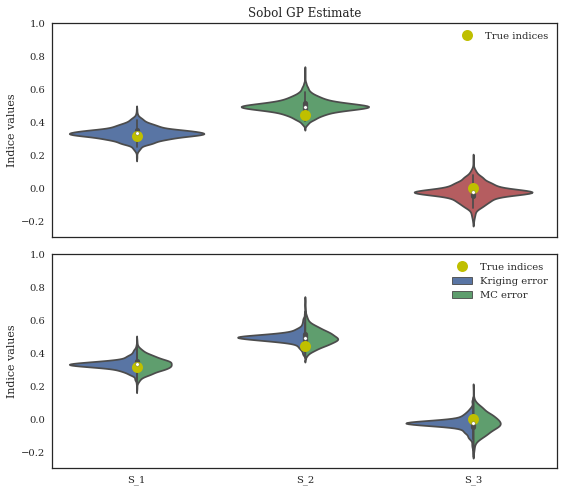

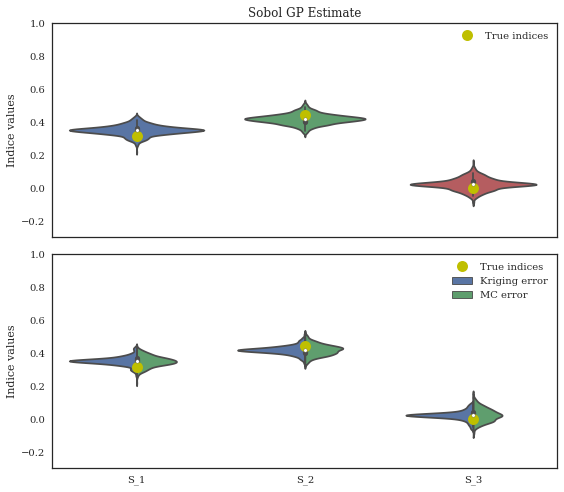

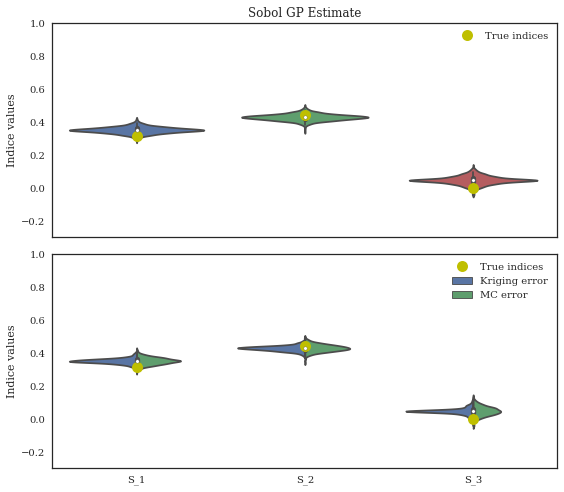

In [6]:
max_budgets = [50, 500]
n_samples = [100, 500, 1000, 2000]
n_boot = 1000
n_realization = 300
ylim = [-.3, 1.]
with_MC_estimate = False
mean_method = True
savefig = True

sobol = SobolIndices(input_distribution)
sobol_kriging = SobolKrigingIndices(input_distribution)
evaluate_together = True
indiv_bootstraps = False

for max_budget in max_budgets:
    if with_MC_estimate:
        sobol.build_mc_sample(model, int(max_budget/(2*dim)))
        first_indices_mc = sobol.compute_indices(n_boot=n_boot)
        df_first_indices_mc = create_df_from_mc_indices(first_indices_mc)
        
    meta_model = sobol_kriging.build_meta_model(model, n_sample=max_budget)
    
    for n_sample in n_samples:
        t_start = time.time()
        print('n_sample_gp: %d, max_budget: %d' % (n_sample, max_budget))

        sobol_kriging.build_mc_sample(meta_model, n_sample, n_realization, evaluate_together=evaluate_together)
        first_indices_gp = sobol_kriging.compute_indices(n_boot=n_boot, indiv_bootstraps=indiv_bootstraps)

        var_tot = first_indices_gp.reshape(dim, -1).var(axis=1)
        var_MC = first_indices_gp.var(axis=2).mean(axis=1)
        var_gp = first_indices_gp.var(axis=1).mean(axis=1)
        print('MC var:', var_MC)
        print('Kriging var:', var_gp)
        print('Sum of vars:', var_gp + var_MC)
        print('Total var:', var_tot)

        if with_MC_estimate:
            df_first_indices_mc = create_df_from_indices(first_indices_mc)
        df_first_indices_gp = create_df_from_gp_indices(first_indices_gp, mean_method=mean_method)

        fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 7))
        ax = axes[0]
        sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, ax=ax)
        ax.set_xlabel('')
        ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
        ax.set_title('Sobol GP Estimate')
        ax.legend(loc=0)
        ax.set_ylim(ylim)

        ax = axes[1]
        sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax, split=True)
        ax.set_xlabel('')
        ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
        ax.legend(loc=0)
        ax.set_ylim(ylim)

        fig.tight_layout()
        if savefig:
            fig.savefig('output/ishigami_sobolGP_n_%d_Nz_%d_m_%d_B_%d.pdf' % (max_budget, n_realization, n_sample, n_boot))
            fig.savefig('output/ishigami_sobolGP_n_%d_Nz_%d_m_%d_B_%d.png' % (max_budget, n_realization, n_sample, n_boot))
        
        if with_MC_estimate:
            fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 10))

            ax = axes[0]
            sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, ax=ax, gridsize=500)
            ax.set_xlabel('')
            ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
            ax.set_title('Sobol GP Estimate')
            ax.legend(loc=0)
            ax.set_ylim(ylim)

            ax = axes[1]
            sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax, split=True, gridsize=500)
            ax.set_xlabel('')
            ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
            ax.set_title('Sobol GP Estimate - Kriging and MC errors')
            ax.legend(loc=0)
            ax.set_ylim(ylim)

            ax = axes[2]
            sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_mc, ax=ax, split=True, gridsize=500)
            ax.set_xlabel('')
            ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
            ax.set_title('Monte Carlo Estimate')
            ax.legend(loc=0)
            ax.set_ylim(ylim)

            fig.tight_layout()
            if savefig:
                fig.savefig('output/ishigami_sobolGP_MC_n_%d_Nz_%d_m_%d_B_%d.pdf' % (max_budget, n_realization, n_sample, n_boot))
                fig.savefig('output/ishigami_sobolGP_MC_n_%d_Nz_%d_m_%d_B_%d.png' % (max_budget, n_realization, n_sample, n_boot))
        
        print('Elapsed time: %.2f s\n' % (time.time() - t_start))